In [1]:
import sys,os

In [2]:
sys.path.append("/opt/notebooks/GPU-GWAS/")
os.chdir("/opt/notebooks/GPU-GWAS/")

In [3]:
import argparse
import time
from collections import defaultdict

import cupy as cp
import cudf
import pandas as pd

import gpugwas.io as gwasio
import gpugwas.algorithms as algos
import gpugwas.viz as viz
import gpugwas.dataprep as dp
import gpugwas.runner as runner

In [4]:
vcf_path='./data/test.vcf'
annotation_path='./data/1kg_annotations.txt'

## Load data into dataframes

In [5]:
# Load data
vcf_df, feature_mapping = gwasio.load_vcf(vcf_path, info_keys=[], format_keys=["GT"])
#vcf_df = cudf.io.parquet.read_parquet("/data/1000-genomes/hail-dataset/1kg_full_jdaw_v2.pqt")
ann_df = gwasio.load_annotations(annotation_path)
print(vcf_df)
print("==")
print(ann_df)

[]
['GT']
       chrom        pos  ref  alt   sample        quality  feature_id  call_GT
0          1     904165    3    1  HG00096   52346.371094           0        0
1          1     904165    3    1  HG00099   52346.371094           0        0
2          1     904165    3    1  HG00105   52346.371094           0        0
3          1     904165    3    1  HG00118   52346.371094           0        0
4          1     904165    3    1  HG00129   52346.371094           0        0
...      ...        ...  ...  ...      ...            ...         ...      ...
252755     1  245840409    2    1  NA21114  185501.015625         889        0
252756     1  245840409    2    1  NA21116  185501.015625         889        1
252757     1  245840409    2    1  NA21118  185501.015625         889        1
252758     1  245840409    2    1  NA21133  185501.015625         889        1
252759     1  245840409    2    1  NA21143  185501.015625         889        1

[252760 rows x 8 columns]
==
       Sampl

## Generate phenotype dataframe by merging vcf and annotation DF

In [6]:
phenotypes_df, n_features = dp.create_phenotype_df(vcf_df, ann_df, ['CaffeineConsumption','isFemale','PurpleHair'],
                                       vcf_sample_col="sample", ann_sample_col="Sample")

Merging annotations
         Sample Population SuperPopulation  isFemale  PurpleHair  \
0       NA19096        YRI             AFR     False       False   
1       NA19113        YRI             AFR     False       False   
2       NA19118        YRI             AFR      True        True   
3       NA19185        YRI             AFR      True       False   
4       NA19209        YRI             AFR      True       False   
...         ...        ...             ...       ...         ...   
252755  HG02131        KHV             EAS     False       False   
252756  HG02152        CDX             EAS      True        True   
252757  HG02154        CDX             EAS      True        True   
252758  HG02165        CDX             EAS      True       False   
252759  HG02224        IBS             EUR     False        True   

        CaffeineConsumption chrom        pos  ref  alt   sample     quality  \
0                         6     1   15987274    2    4  NA19096  222.919998   
1    

## Run PCA on phenotype matrix

In [7]:
# Run PCA on phenotype dataframe
phenotypes_df = algos.PCA_concat(phenotypes_df, 3)
print(phenotypes_df)

      Sample  CaffeineConsumption  isFemale  PurpleHair  variant_0  variant_1  \
0    HG00096                    4     False       False        0.0       -1.0   
1    HG00099                    4      True       False        0.0        0.0   
2    HG00105                    4     False       False        0.0        0.0   
3    HG00118                    3      True       False        0.0        0.0   
4    HG00129                    6     False       False        0.0        0.0   
..       ...                  ...       ...         ...        ...        ...   
279  NA21114                    6     False        True        0.0        0.0   
280  NA21116                    4     False        True        0.0        0.0   
281  NA21118                    6     False       False        0.0        0.0   
282  NA21133                    5     False        True        0.0        0.0   
283  NA21143                    5      True        True        0.0        0.0   

     variant_2  variant_3  

## Run GWAS with linear regression for each independent variant

In [8]:
# Fit linear regression model for each variant feature
print("Fitting linear regression model")

df = runner.run_gwas(phenotypes_df, 'CaffeineConsumption', n_features, algos.cuml_LinearReg)
print(df)

Fitting linear regression model


/opt/notebooks/GPU-GWAS/gpugwas/algorithms.py:97: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  self.model.fit(X, y)


Visualizing p values
     feature  p_value  chrom
0          0    0.986      1
1          1    0.845      1
2          2    0.951      1
3          3    0.952      1
4          4    0.983      1
..       ...      ...    ...
885      885    0.995      1
886      886    0.997      1
887      887    0.994      1
888      888    0.998      1
889      889    0.990      1

[890 rows x 3 columns]


In [9]:
df["feature"]

0        0
1        1
2        2
3        3
4        4
      ... 
885    885
886    886
887    887
888    888
889    889
Name: feature, Length: 890, dtype: int64

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

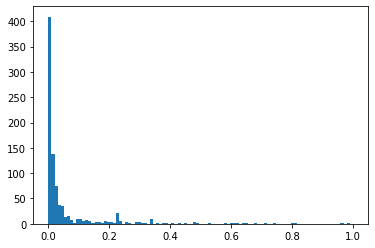

In [11]:
plt.hist(-np.log(df["p_value"].to_array()), bins = np.linspace(0,1,100));

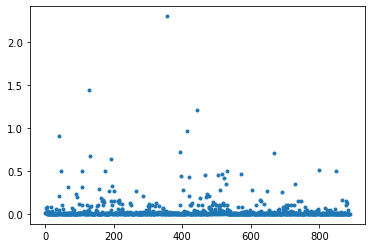

In [12]:
plt.plot(df["feature"].to_array(), -np.log10(df["p_value"].to_array()), ".");

In [13]:
a = df["p_value"].to_array()
a.sort()
expect_p = np.linspace(0, 1, len(a))

<ipython-input-14-eaedea241370>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log10(expect_p), -np.log10(a), '.')


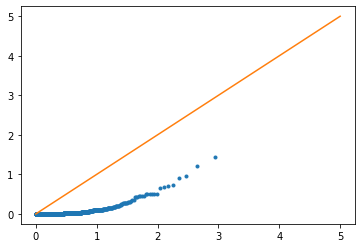

In [14]:
plt.plot(-np.log10(expect_p), -np.log10(a), '.')
plt.plot([0,5],[0,5])

In [15]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show

output_notebook()

plot = figure()
plot.circle(-np.log10(expect_p+1e-10), -np.log10(a))

handle = show(plot, notebook_handle=True)

# Update the plot title in the earlier cell
plot.title.text = "qqplot"
push_notebook(handle=handle)

Loading BokehJS ...

In [16]:
!wget https://www.broadinstitute.org/files/shared/diabetes/scandinavs/DGI_chr3_pvals.txt

--2020-11-08 17:18:13--  https://www.broadinstitute.org/files/shared/diabetes/scandinavs/DGI_chr3_pvals.txt
Resolving www.broadinstitute.org (www.broadinstitute.org)... 3.213.107.188, 18.209.128.94
Connecting to www.broadinstitute.org (www.broadinstitute.org)|3.213.107.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327162 (319K) [text/plain]
Saving to: ‘DGI_chr3_pvals.txt.3’

DGI_chr3_pvals.txt. 100%[===================>] 319.49K  --.-KB/s    in 0.005s  

2020-11-08 17:18:13 (61.3 MB/s) - ‘DGI_chr3_pvals.txt.3’ saved [327162/327162]



In [17]:
pvals = []
with open('DGI_chr3_pvals.txt') as f:
    for r in f:
        r = r.strip()
        if r == 'PVAL':
            continue
        pvals.append(float(r))
pvals = np.array(pvals)

In [18]:
pvals.sort()
expect_p = np.linspace(0, 1, len(pvals))

<ipython-input-19-5331b67c4701>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log10(expect_p), -np.log10(pvals), '.')


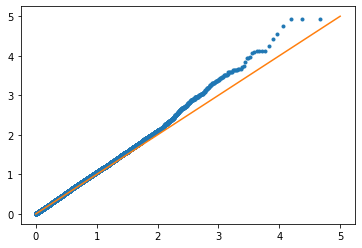

In [19]:
plt.plot(-np.log10(expect_p), -np.log10(pvals), '.')
plt.plot([0,5],[0,5])

In [20]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
f#rom bokeh.models import Range1d

output_notebook()


plot = figure(plot_width=300, plot_height=300, 
              y_range=(0,5),
              x_range=(0,5))
plot.circle(-np.log10(expect_p+1e-10), -np.log10(pvals))
plot.line([0,5],[0,5])

handle = show(plot, notebook_handle=True)

# Update the plot title in the earlier cell
plot.title.text = "qqplot"
push_notebook(handle=handle)

Loading BokehJS ...

In [21]:
pvals

array([7.094e-06, 1.196e-05, 1.196e-05, ..., 1.000e+00, 1.000e+00,
       1.000e+00])